<a href="https://colab.research.google.com/github/Alexandre-Hefren/Machine-Learning-models/blob/main/Multi_class_Logist_Regression_and_feedforward_of_Neural_Network_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Logistic regression for multi-class classification and Neural Networks



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

The problem of digit recognition is a multi-class classification since we would like to distinguish  handwritten digits, all of them (from 0 to 9). This is naturally an generalization of the binary classification problem where we only have two outcomes, ex: 0 (False) and 1 (True).

We have a MATLAB file (.mat) that will be imported for this task.

In [ ]:
#from scipy import io
from scipy.io import loadmat
from scipy.io import savemat

digits = loadmat('/content/drive/MyDrive/Machine_Learning_DS/Material/ML_Standford/ex3-octave/ex3data1.mat')

x = np.array(digits['X'])  #capital X will be used when including bias and x0
y = np.array(digits['y'])


print(x.shape)
print(y.shape)


y
#note: digit 0 is being represented by number 10. That is a choice for convenience.

(5000, 400)
(5000, 1)


array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=uint8)

In [ ]:
y   #the target contains 10 classes of digits: y is either 1,2,3...10 (10 represents 0)

array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=uint8)

In [ ]:
#There are 5000 digit examples and each digit is an image represented by 20x20 pixels (grey scale) squared.
#For each example, the grid of 20x20 is "unrolled" into a a 400-dimensional vector
m, n = x.shape  # m examples and n pixels

#NOTE: The pixels of each example became a row vector, hence there are 400 columns 

#Visualization of the digits

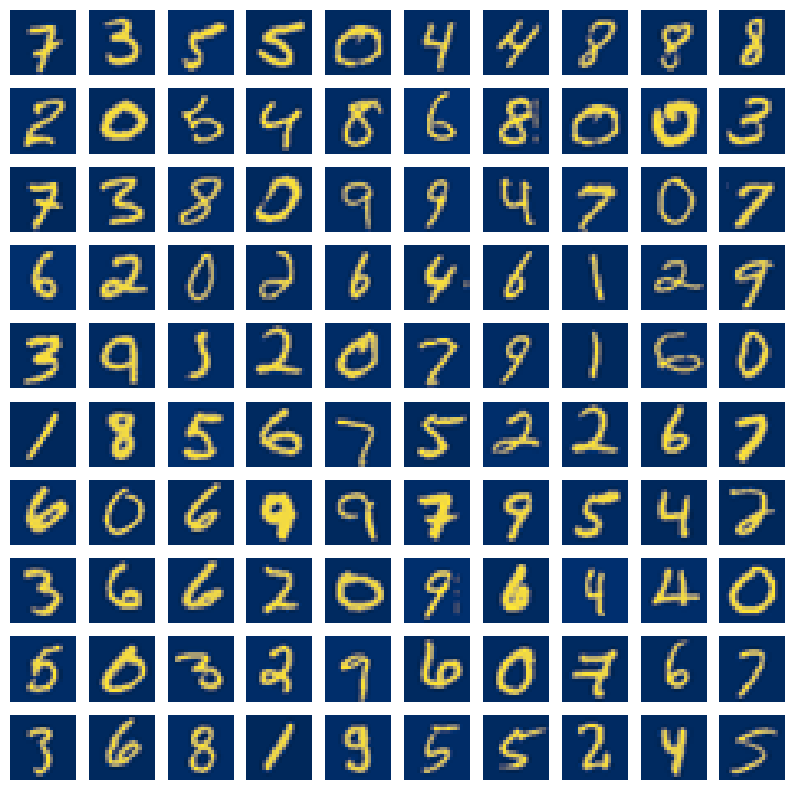

In [ ]:
import random  #python 

#Recall:
#np.random.randit Return random integers from low (inclusive) to high (exclusive).
#random.randint() is inclusive
#random.range() is exclusive

fig, ax = plt.subplots(10, 10, figsize=(10,10))

for i in range(10):
  for j in range(10):
    x_sample = x[np.random.randint(0,5001),:].reshape(20,20).T     #randomly pick up an example (row) keeping all the corresponding pixels
    ax[i,j].imshow(x_sample, cmap='cividis' )                      #we are chossing only 100 examples to have a look
    ax[i,j].axis('off')

#alternatively: can use the Python Image Library (PIL) PIL: Image

#Cost function

As before, our cost function is related to the logistic regression model, where
we used the cross-entropy cost function with a sigmoid function $g$. 
The cost function was mentioned before in our logistic regression notebook (Logistic Regression_model.ipynb) and is given, in the presence of regularization, by
$$J(\theta) = \frac{1}{m} \left[ \sum_{i=1}^{m} -y^{(i)}\ln h^{(i)} - (1 - y^{(i)})\ln (1 - h^{(i)})  \right]  + \frac{\lambda}{2m} \sum_{j=1}^{n} \theta^2_j $$
where $h^{(i)}$ simply denotes the hypothesis function evaluated with the i-th example from the dataset, meaning we use the simpler notation $h^{(i)} = h^{(i)}_{g}(\theta) = g(\theta^t X^{(i)})$ ommiting the dependence on the function $g$. The second term is the regularization term that is controlled by the parameter $\lambda$, the strength of the regularization. The number of examples is given by $m$ and the number of features is given by $n$.

The derivative of the cost function with respect a particular weight $\theta_j$ is
$$\frac{\partial J}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} \left(h^{(i)} - y^{(i)} \right) X_j^{(i)} + \frac{\lambda}{m}  \theta_j. $$

The gradient of the cost function is a crucial information for the learning process even when one does not use gradient descent but other optimization methods. Note that for $j=0$ the gradient has only a contribution from the first term, namely, the loss associated with each term $ \left(h^{(i)} - y^{(i)} \right)$, but for all other $j \neq 0$ the gradient is composed of two parts: the first one associated with the loss and the second one associated with the regularization term.

Note that, in our notation, the following relation holds true: 
$X^{(i)}_j = \left\{
	\begin{array}{ll}
	 1, \quad j=0, \\[0.1cm]
	 x^{(i)}_j, \quad j \neq 0 .
	\end{array}
\right. $

In [ ]:
#we need to apply a sigmoid function to create the hypothesis.
def sigmoid(s):
  return 1/(1 + np.exp(-s))

In [ ]:
np.ones(3)

array([1., 1., 1.])

In [ ]:
#lets add the bias now. For that, we include x0=1

X = np.append(np.ones((m,1)), x, axis=1)
#altenatively: using hstack np.hstack( np.ones , x )

m, n = X.shape #updating size values with extended X

X.shape   #note that 'n' was redefined

(5000, 401)

In [ ]:
# Note: theta first argument because we will use an optimization method
#that takes first argument as variable only.
def cost_functionReg(theta, X, y, LAMBDA):           #'lambda' is reserved...
  """Calculate the regularized cost function for logistic regression"""
  m = len(y)
  #global m                      # m = X.shape[0]
  h = sigmoid(np.dot(X, theta))   #hypothesis adjusted from linear regression (identity>>sigmoid)
  
  regularization = LAMBDA/(2*m) * np.transpose(theta[1:]   ) @ theta[1:]  #Do not regularize the bias 
  cost = (1/m) * ( -y.T @ np.log(h) -(1 - y.T)@ np.log(1-h) )
  regcost = cost + regularization
  return  regcost

In [ ]:
#We know the gradient of our cost function wrt parameters theta 
#instead of ascendent gradient (maximizing a function -log) we use the 
#conjugate gradient method

def gradientReg(theta, X, y, LAMBDA):
  h = sigmoid(np.dot(X, theta))
  m = len(y)
  #theta = theta.reshape((n,1))  in case theta is given as an array instead matrix
  grad_regularization = (LAMBDA/m) * theta
  grad_regularization[0] = 0                # set the regularization term to zero for theta0 = theta[0]
  grad_usual = (1/m) *  np.dot(X.T, (h-y))
  reggrad = grad_usual + grad_regularization
  return reggrad

#Multi-class classification 
One way of doing that for the ten digits, is to use the One-vs-all classification, where logistic regression is used between pair of different classes. If we have just a binary classification, logistic regression will decide if an example is 0 or 1. If we have three classes (1,2,3), we can treat each class as a True value individually: decide if an example is class-1 or not class-1, decide if it is class-2 or not class-2 and, finally, decide if an example is class-3 or not class-3. To do that process, we can generate a column vector with predictions for each class. Hence, three columns. 
Similarly, for $K$ classes, we will have $K$ column vectors of predictions. The weights are given by the matrix 
$\theta \in \mathbb{R}^{(K, n )} $, where $n$ now stands for the number of columns of $X$ after taking bias into account, effectively $(n+1)$ becomes the new redefined value $n$. 
Note that the GIVEN target $y$ is a column vector with 5000 rows in which $y \in \{1, 2, 3, \ldots , 10 \}$. 

For a list of optmization methods with scipy see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
Type of solver. Should be one of
‘Nelder-Mead’‘Powell’ ‘CG’  ‘BFGS‘ Newton-CG’ ‘L-BFGS-B’ ‘TNC’ ‘COBYLA’ ‘SLSQP’ ‘trust-constr’ ‘dogleg’ ‘trust-ncg’ ‘trust-exact’ ‘trust-krylov’, custom 



In [ ]:
from scipy import optimize

def oneVsAll(X, y, K, LAMBDA):
  """Given training examples, number of classes= K and regularization parameter, find the  theta matrix
  that will minimize the cost function. This will train K logistic regression classifiers and use optimization methods to learn the weights  """
  n = X.shape[1]
  theta_all = np.zeros((K,n)) #all thetas
  
  for c in range(1,K+1):                                #c=1,2,...10 when K=10
    theta_single = np.zeros((n,1))
    theta_single= theta_single.reshape((n,))
    y= y.reshape((m,))

#y==c is the crucial step where we change the multi-class targets(1 to 10) to become ones and zeros (needed for logistic regression)  
#wherever y==c, we want a 1. otherwise, we want a 0.
    result = optimize.minimize(cost_functionReg, theta_single, args=(X, np.where(y==c, 1, 0 ) , LAMBDA), method='CG',
                               jac = gradientReg, options={'maxiter': 5000, 'disp':True } )
    #where(condition , a, b) output is: ndarray-An array with elements from `a` where `condition` is True, and elements from `b` elsewhere.     
    #                      
                  
    theta_min = result['x']
    theta_all[c-1, :] = theta_min       #when c=1 , c-1 = 0

    
  return theta_all 

#restart the original shapes
y= y.reshape((m,1))
#theta_min = theta_min.reshape((n,1))


#note: jac is Jacobian. Give the method; our gradient function defined above.
#it should be a function that returns the gradient vector:
#jac(x, *args) -> array_like, shape (n,)
#where x is an array with shape (n,) and args is a tuple with the fixed parameters.

#args is a tuple of the fixed parameters needed to completely specify the function.
#maxiter for maximum iterations
#disp for printing convergence messages

# returns: The optimization result represented as a OptimizeResult object. 
#Important attributes are: x the solution array, success a Boolean flag indicating 
#if the optimizer exited successfully and message which describes the cause of the termination. 


#alternatively
#result2 = optimize.fmin_tnc(func= cost_function, x0= theta, fprime=gradient, args= (X, y) )  


In [ ]:
#In particular, we check the case: K=10 (ten classes) and small regularization parameter LAMBDA=0.1 
K=10
LAMBDA=0.1

theta_all = oneVsAll(X, y, K, LAMBDA)


# shape is (10,401) when K=10  (K, n)
#Note the optimization will run 10 times

Optimization terminated successfully.
         Current function value: 0.013122
         Iterations: 108
         Function evaluations: 417
         Gradient evaluations: 417
Optimization terminated successfully.
         Current function value: 0.050814
         Iterations: 225
         Function evaluations: 693
         Gradient evaluations: 693
Optimization terminated successfully.
         Current function value: 0.057611
         Iterations: 212
         Function evaluations: 637
         Gradient evaluations: 637
Optimization terminated successfully.
         Current function value: 0.033080
         Iterations: 185
         Function evaluations: 620
         Gradient evaluations: 620
Optimization terminated successfully.
         Current function value: 0.054471
         Iterations: 208
         Function evaluations: 610
         Gradient evaluations: 610
Optimization terminated successfully.
         Current function value: 0.018267
         Iterations: 153
         Function ev

The prediction goes as follows: 

In [ ]:
#The prediction process
#X is a (mxn) matrix  and theta_all is (Kxn)  
# (X theta_all.T) is (mxK) 

#For each row, one example, we want the position (given by the column axis=1) which has the maximum value
#among all the numbers in that row. We will obtain m numbers, that is, one for each example. 
#the max value finds the value which is the closest to 1 (output of sigmoid on True value) and the argmax tells
#the column position (hence telling what is the Digit) associated with this maximum value. 

hypo = sigmoid(X @ np.transpose(theta_all))  #hypothesis
np.argmax(hypo, axis=1 ) #but note the positions run from 0 to 9 (python)

#axis=1 means we run over the columns but keeping row fixed

array([9, 9, 9, ..., 8, 8, 6])

In [ ]:
#we need these numbers in a column vector to compare
#with the given label y that is of type (m, 1)
print(np.argmax(hypo, axis=1 ).shape)

#we can reshape to the required dimension
np.argmax(hypo, axis=1 ).reshape(m,1)

(5000,)


array([[9],
       [9],
       [9],
       ...,
       [8],
       [8],
       [6]])

In [ ]:
#We wan to compare the predictions with the labels y, the latter has values ranging from 1 to 10...
#increase the position of each by one. now, it runs from 1 to 10.
np.argmax(hypo, axis=1 ).reshape(m,1) + 1 

array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 7]])

In [ ]:
#Now we are in the position of comparing prediction and given labels
#calculate the percentage of True values as result of this comparison!

prediction = np.argmax(hypo, axis=1 ).reshape(m,1) + 1 

accuracy = np.mean( prediction == y) *100

f'the accuracy of the model is of {accuracy} %'

'the accuracy of the model is of 96.44 %'

In [ ]:
#Reminder: The entire data is being used for training only.

#Neural Networks (feedforward)

Now, the same training set, handwritten digits, can be used to train a simple neural network instead of the multi-class classification with logistic regression used above. In this example, the weights were included in the file lodaded below and denoted 'weights'. Similarly to the previous case of one-Vs-all, we want to to train a model to work with digit recognition. However, with a neural network we do not need to train $K$-times a logistic regression model, because hidden layers have a similar effect in which some intermediate steps will connect the input layer to the output layer. For the present case, a single hidden layer is enough without requiring too many hidden units. The activation function used will be the sigmoid in similarity to logistic regression. In the next notebook, we will use neural network not actually train the model,  and that is where backpropagation is crucially needed. Thus, backpropagation is left to the next notebook.  

We will denote incoming and outgoing layers the pair of layers involved at each step in a neural network such that incoming is related to the starting (start from) and outgoing is related to the ending (ends at). While input layer and output layer are fixed notions, incoming and outgoing help to keep track of the direction of propagation at a particular step.
In our case, there is only one hidden layer, and the size of this hidden layer is determined by the number of hidden units $=25$, before adding bias.
We will see that $\theta_1$ has shape $(25,401)$ and $\theta_2$ has shape $(10,26)$.

Note that $X$ has shape $(m,N_{\textrm{in}})$ and $\theta$ have shape $(N_{\textrm{out}}, N_{\textrm{in}} )$ where $m$ is the number of training examples, and $N_{\textrm{in}}, N_{\textrm{out}}$ are the number of units from the incoming layer and outgoing layer, respectively. For example, starting from the input layer, the incoming layer is  the input layer and the outgoing layer is the first hidden layer. At the second step of the feedforward process, the incoming layer is the first hidden layer and the outgoing is the second hidden layer. The process continues until, in the last step, the moment when the outgoing layer is the output layer (and obviously, the incoming layer is the last hidden layer, just one layer before the output). The formulas found in the literature vary a lot because people use different notations. Particularly, it is common to have the weights defined the other way: the first dimension is determined by the incoming layer and the second dimension is determined by the outgoing layer. It is important to remember adding bias during the feedforward process. As before, we always denoteby  $x$ the matrix of features without bias, and by $X$ the extended matrix taking bias into account. Thus, the map $x \mapsto X$ is basically appending a collumn vector $x_0$ made of ones. Let $a^{(1)}$ be our matrix $X$. Then, 
$$a^{(1)} = X $$
$$z^{(2)} =  a^{(1)} \theta_1^t $$
$$ a^{(2)} = f(z^{(2)})$$
bias is added to $a^{(2)}$

$$z^{(3)} =  a^{(2)} \theta_2^t $$
$$a^{(3)} = f(z^{(3)}) $$

where $f$ is the activation function. Here $f$ will be the sigmoid function only. Note also, in particular, that $a^{(1)}$ has shape $(5000, 401)$, $z^{(2)}$ has shape $(5000, 25)$, $a^{(2)}$ has, after introducing bias, shape $(5000, 26)$, $z^{(3)}$ has shape $(5000,10)$, and $a^{(3)}$ has also has shape $(5000,10)$, because it is the last activation leading to the output, it can be seen as the hypothesis $h(\theta; X)$ of the model.
The labels $y$ given to us are represented by a column vector of shape $(5000,1)$. Because we need to compare our network output with the given labels, it is clear that, given an example, we need $1$ value instead of $10$. The reduction from $10$ to a single number follows from the fact that the outputs are probabilities indicating how likely a given example is represented by one of the ten digits. Since these are probabilities, we say that the digit with the highest probability shall be chosen as our prediction for the given example.
Hence, the prediction will be a column vector of shape $(5000, 1)$, exactly as $y$. By comparing how many times our prediction agrees with the labels, we have a measure of the model's accuracy, namely, the accuracy of this neural network.  


Picture taken from Coursera - Stanford- Machine Learning.
The neural network with only one hidden layer that we use here.








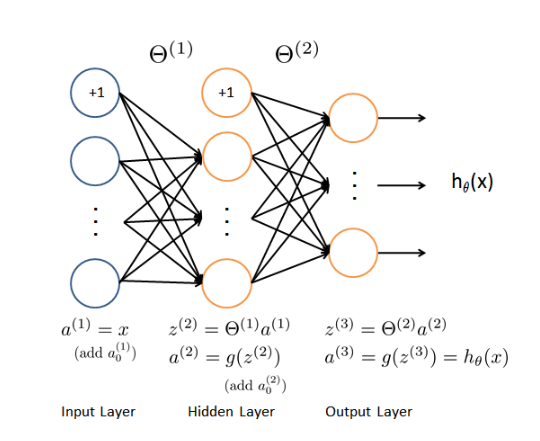




In [ ]:
#given the data, let's load it.
#For this example, not only the training examples are given but also the weights theta already learned.

weights = loadmat('/content/drive/MyDrive/Machine_Learning_DS/Material/ML_Standford/ex3-octave/ex3weights.mat')

theta1 = weights['Theta1']
theta2 = weights['Theta2']

print(theta1.shape) #theta1 has size  25x401  , the inpput layer has 20x20=400 compoents plus 1 bias giving 401
print(theta2.shape)  #theta2 has size 10x26  , 26 = 25 +1 (a bias term was added). the output has 10 components corresponding to the 10 digits {0...9}


(25, 401)
(10, 26)


In [ ]:
X.shape

(5000, 401)

In [ ]:
y.shape  #but y considered that 0 is actually a 10 (given data)

(5000, 1)

In [ ]:
y

array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=uint8)

In [ ]:
#The forward propagation or feedforward

def net_function(z):
  return 1/(1 + np.exp(-z))


def predict(theta1, theta2, X):
  """Given the weights of a neural network (already trained) and the training examples X, predict what is the digit associated with each given example """
  m = X.shape[0]

  #a1 = np.append(np.ones((m,1)), x, axis=1 )
  a1 = X  #already taken bias into account   (m,401)
  z2 = a1 @ theta1.T                      #    (m,25)
  a2 = net_function(z2)                     #(m,25) 
  a2 = np.append(np.ones((m,1)), a2, axis=1 ) #(m, 26)
  z3 = a2  @ theta2.T                           #(m,10) 
  a3 = net_function(z3)  #output of shape  (m,10)
  print(f'For example, the first example has the following output a3: {a3[0]}, where just one number (the greatest) will predict the digit from the probabilities of each position ')

  return np.argmax(a3, axis=1)+1   #sum +1 on the position, because the labels y are given as {1...10} where 0 is mapped to 10 









In [ ]:
result = predict(theta1, theta2, X)

print(result.shape)
result = result.reshape(m,1) #reshape to correct dimension for comparison with y
print('----'*33)
result

For example, the first example has the following output a3: [1.12661530e-04 1.74127856e-03 2.52696959e-03 1.84032321e-05
 9.36263860e-03 3.99270267e-03 5.51517524e-03 4.01468105e-04
 6.48072305e-03 9.95734012e-01], where just one number (the greatest) will predict the digit from the probabilities of each position 
(5000,)
------------------------------------------------------------------------------------------------------------------------------------


array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]])

In [ ]:
#Finally, the accuracy is obtained fro the comparison 
print(f'The model accuracy is {np.mean(result == y)*100}%  ')

The model accuracy is 97.52%  
